In [61]:
import pandas as pd

In [62]:
cars_cleaned = pd.read_csv('../../data/scrapped/voitures_clean.csv')
cars_cleaned.head()

,Ville,Marque,Modèle,Année-Modèle,Kilométrage,Type de carburant,Puissance fiscale,Boite de vitesses,Nombre de portes,Origine,Première main,Prix,Ville_grouped,Age_vehicule
0,Temara,Fiat,Punto,2007,224999.5,Diesel,5.0,Manuelle,5.0,WW au Maroc,Non,60000.0,Temara,18
1,Casablanca,Volkswagen,Touareg,2005,2499.5,Diesel,10.0,Automatique,5.0,WW au Maroc,Oui,90000.0,Casablanca,20
2,Dakhla,Toyota,Prado,2007,224999.5,Diesel,12.0,Manuelle,5.0,WW au Maroc,Non,97000.0,Autres,18
3,Khouribga,Volkswagen,Tiguan,2014,184999.5,Diesel,8.0,Automatique,5.0,Dédouanée,Non,255000.0,Autres,11
4,Meknès,Peugeot,308,2009,224999.5,Diesel,6.0,Manuelle,5.0,WW au Maroc,Non,85000.0,Meknès,16


In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [64]:
df3 = cars_cleaned.copy()
df4 = cars_cleaned.copy()
df5 = cars_cleaned.copy()
df6 = cars_cleaned.copy()
df7 = cars_cleaned.copy()
df8 = cars_cleaned.copy()
df9= cars_cleaned.copy()

# Régression lineaire multiples avec Prix

In [65]:
df3 = df3.drop(columns=['Ville','Année-Modèle'])
# ==== TARGET ENCODING POUR MARQUE ET MODÈLE ====
for col in ['Marque', 'Modèle']:
    means = df3.groupby(col)['Prix'].mean()
    df3[col + '_te'] = df3[col].map(means)

# Supprimer les colonnes originales
df3 = df3.drop(columns=['Marque', 'Modèle'])

# ==== ONE-HOT POUR AUTRES CATÉGORIELLES ====
df3_encoded = pd.get_dummies(
    df3,
    columns=['Boite de vitesses', 'Type de carburant', 'Origine', 'Première main','Ville_grouped'],
    drop_first=True
)

# ==== VARIABLES NUMÉRIQUES + CATÉGORIELLES ====
X = df3_encoded.drop(['Prix'], axis=1)
y = df3_encoded['Prix']

# ==== SPLIT TRAIN / TEST ====
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==== STANDARDISATION UNIQUEMENT DES VARIABLES NUMÉRIQUES ====
from sklearn.preprocessing import StandardScaler
num_cols = ['Kilométrage', 'Age_vehicule', 'Nombre de portes', 'Puissance fiscale','Marque_te','Modèle_te']
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

# ==== ALIGNEMENT DES COLONNES ====
X_train_scaled, X_test_scaled = X_train_scaled.align(X_test_scaled, join='left', axis=1, fill_value=0)
# ==== MODÈLE RÉGRESSION LINÉAIRE ====
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# ==== PRÉDICTIONS ====
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# ==== ÉVALUATION ====
def evaluate_model(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\nPerformance sur {dataset_name}:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")
    return rmse, r2

# ==== ÉVALUATION DES PERFORMANCES ==== 
rmse_train, r2_train = evaluate_model(y_train, y_pred_train, "Train")
rmse_test, r2_test = evaluate_model(y_test, y_pred_test, "Test")



Performance sur Train:
MSE: 1046978882.23
RMSE: 32357.05
R²: 0.7665

Performance sur Test:
MSE: 1075109109.14
RMSE: 32788.86
R²: 0.7615


Les performances de notre dataset avec la colonne Prix

# Histrogramme de la colonne Prix avant et après Log1p()

Prix – min : 20000.0  max : 320000.0


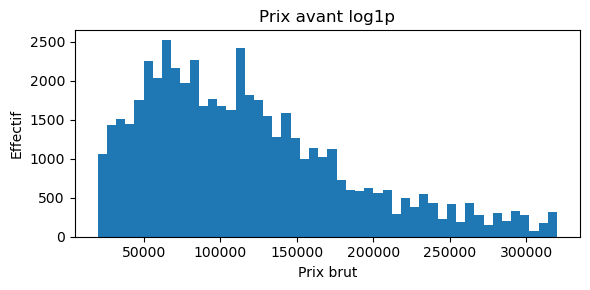

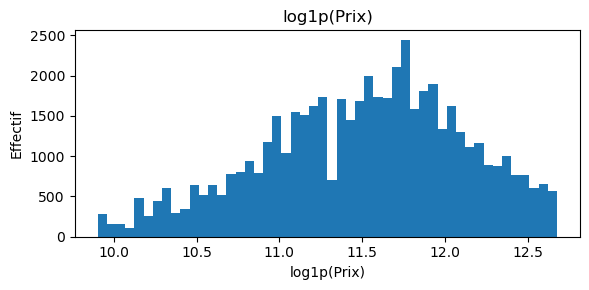

logPrix – min : 9.90353755128617  max : 12.676079399771027


In [66]:
print("Prix – min :", df5['Prix'].min(), " max :", df5['Prix'].max())

# 1) Histogramme du prix AVANT log‑transform
plt.figure(figsize=(6,3))
plt.hist(df5['Prix'], bins=50)
plt.title("Prix avant log1p")
plt.xlabel("Prix brut")
plt.ylabel("Effectif")
plt.tight_layout()
plt.show()

# 2) Création de la cible log‑transformée
df5['logPrix'] = np.log1p(df5['Prix'])

# 3) Histogramme du prix APRÈS log‑transform
plt.figure(figsize=(6,3))
plt.hist(df5['logPrix'], bins=50)
plt.title("log1p(Prix)")
plt.xlabel("log1p(Prix)")
plt.ylabel("Effectif")
plt.tight_layout()
plt.show()

# Vérification numérique post‑transform
print("logPrix – min :", df5['logPrix'].min(), " max :", df5['logPrix'].max())

La distribution brute du prix est fortement étalée et asymétrique (de 60000 DH à 237000 DH ), ce qui peut nuire aux modèles linéaires . 

Nous avons donc appliqué la transformation suivante : df['logPrix'] = np.log1p(df['Prix']).

L’histogramme “Avant log1p” montre une longue queue à droite, tandis que "log1p[Prix]" la distribution devient plus symétrique (centrée entre 11 et 12.37), stabilisant la variance et facilitant l’apprentissage.

# Régression linéaire multiple avec Log1p(Prix) avec Année-Modèle

In [67]:
df6 = df6.drop(columns=['Ville'])

df6['logPrix'] = np.log1p(df6['Prix'])
# ==== TARGET ENCODING POUR MARQUE ET MODÈLE ====
for col in ['Marque','Modèle']:
    means = df6.groupby(col)['logPrix'].mean()
    df6[col + '_te'] = df6[col].map(means)
df6 = df6.drop(columns=['Marque','Modèle'])

# ==== ONE-HOT POUR AUTRES CATÉGORIELLES ====
df6_encoded = pd.get_dummies(
    df6,
    columns=['Boite de vitesses','Type de carburant','Origine','Première main',"Ville_grouped"],
    drop_first=True
)

# ==== VARIABLES NUMÉRIQUES + CATÉGORIELLES ====
X = df6_encoded.drop(['Prix','logPrix'], axis=1)
y = df6_encoded['logPrix']  # on va prédire logPrix

# ==== SPLIT TRAIN / TEST ====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==== STANDARDISATION UNIQUEMENT DES VARIABLES NUMÉRIQUES ====
num_cols = ['Kilométrage', 'Année-Modèle', 'Nombre de portes', 'Puissance fiscale','Marque_te','Modèle_te']
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

# ==== ALIGNEMENT COLONNES TRAIN / TEST (optionnel mais sûr) ====
X_train_scaled, X_test_scaled = X_train_scaled.align(X_test_scaled, join='left', axis=1, fill_value=0)
# ==== RÉGRESSION LINÉAIRE SUR LOG PRIX ====
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# ==== PRÉDICTIONS ====
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# ==== ÉVALUATION ====
def evaluate_model(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    
    # Accuracy ±10% sur prix réel
    y_true_real = np.exp(y_true)
    y_pred_real = np.exp(y_pred)

    print(f"\nPerformance sur {dataset_name}:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")
    return rmse, r2

rmse_train, r2_train = evaluate_model(y_train, y_pred_train, "Train")
rmse_test, r2_test = evaluate_model(y_test, y_pred_test, "Test")


Performance sur Train:
MSE: 0.06
RMSE: 0.25
R²: 0.8379

Performance sur Test:
MSE: 0.06
RMSE: 0.25
R²: 0.8332


# Régression linéaire multiple avec Log1p(Prix) avec Age_vehicule

In [68]:
df4 = df4.drop(columns=['Ville','Année-Modèle'])

df4['logPrix'] = np.log1p(df4['Prix'])
# ==== TARGET ENCODING POUR MARQUE ET MODÈLE ====
for col in ['Marque','Modèle']:
    means = df4.groupby(col)['logPrix'].mean()
    df4[col + '_te'] = df4[col].map(means)
df4 = df4.drop(columns=['Marque','Modèle'])

# ==== ONE-HOT POUR AUTRES CATÉGORIELLES ====
df4_encoded = pd.get_dummies(
    df4,
    columns=['Boite de vitesses','Type de carburant','Origine','Première main',"Ville_grouped"],
    drop_first=True
)

# ==== VARIABLES NUMÉRIQUES + CATÉGORIELLES ====
X = df4_encoded.drop(['Prix','logPrix'], axis=1)
y = df4_encoded['logPrix']  # on va prédire logPrix

# ==== SPLIT TRAIN / TEST ====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==== STANDARDISATION UNIQUEMENT DES VARIABLES NUMÉRIQUES ====
num_cols = ['Kilométrage', 'Age_vehicule', 'Nombre de portes', 'Puissance fiscale','Marque_te','Modèle_te']
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

# ==== ALIGNEMENT COLONNES TRAIN / TEST (optionnel mais sûr) ====
X_train_scaled, X_test_scaled = X_train_scaled.align(X_test_scaled, join='left', axis=1, fill_value=0)
# ==== RÉGRESSION LINÉAIRE SUR LOG PRIX ====
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# ==== PRÉDICTIONS ====
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# ==== ÉVALUATION ====
def evaluate_model(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    
    # Accuracy ±10% sur prix réel
    y_true_real = np.exp(y_true)
    y_pred_real = np.exp(y_pred)

    print(f"\nPerformance sur {dataset_name}:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")
    return rmse, r2

rmse_train, r2_train = evaluate_model(y_train, y_pred_train, "Train")
rmse_test, r2_test = evaluate_model(y_test, y_pred_test, "Test")

coefficients = pd.DataFrame({'Feature': X_train_scaled.columns, 
                             'Coefficient': model.coef_}).sort_values('Coefficient', ascending=False)
print("Coefficients du modèle:")
print(coefficients)
print(f"\nIntercept: {model.intercept_:.2f}")


Performance sur Train:
MSE: 0.06
RMSE: 0.25
R²: 0.8379

Performance sur Test:
MSE: 0.06
RMSE: 0.25
R²: 0.8332
Coefficients du modèle:
                         Feature  Coefficient
5                      Modèle_te     0.188565
11         Type de carburant_LPG     0.152872
14             Première main_Oui     0.061783
4                      Marque_te     0.048642
26           Ville_grouped_Rabat     0.032351
24           Ville_grouped_Nador     0.028255
1              Puissance fiscale     0.022001
31         Ville_grouped_Tétouan     0.019753
22          Ville_grouped_Meknès     0.012254
19             Ville_grouped_Fès     0.009662
29          Ville_grouped_Tanger     0.003205
2               Nombre de portes     0.002713
25           Ville_grouped_Oujda     0.002500
20         Ville_grouped_Kénitra     0.000930
16     Ville_grouped_Béni Mellal    -0.001236
21       Ville_grouped_Marrakech    -0.005012
28            Ville_grouped_Salé    -0.006461
30          Ville_grouped_Temara    -

----> Pour préparer les données à l’entrée des algorithmes de régression, toutes les colonnes textuelles ont été transformées en variables numériques :

1- One‑hot encoding pour les variables à faible cardinalité('Boite de vitesses','Type de carburant','Origine','Première main'), chaque modalité est devenue une colonne binaire(True/False)

2- Target encoding pour les variables à haute cardinalité (plusieurs modalités) comme Marque et Modèle. Chaque catégorie a été remplacée par la moyenne de la cible log‑transformée (logPrix) au sein de cette catégorie. Cette méthode conserve l’information prédictive de chaque modalité en une seule colonne continue, évitant l’explosion dimensionnelle du one‑hot.

Dans cette étape, notre jeu de données est entièrement numérique, sans variables textuelles, et dimensionné de manière optimale (14 columns) pour l’entraînement de modèles

# Ridge 

In [69]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, RidgeCV
import numpy as np

df7 = df7.drop(columns=['Ville','Année-Modèle'])

df7['logPrix'] = np.log1p(df7['Prix'])
# ==== TARGET ENCODING POUR MARQUE ET MODÈLE ====
for col in ['Marque','Modèle']:
    means = df7.groupby(col)['logPrix'].mean()
    df7[col + '_te'] = df7[col].map(means)
df7 = df7.drop(columns=['Marque','Modèle'])

# ==== ONE-HOT POUR AUTRES CATÉGORIELLES ====
df7_encoded = pd.get_dummies(
    df7,
    columns=['Boite de vitesses','Type de carburant','Origine','Première main',"Ville_grouped"],
    drop_first=True
)

# ==== VARIABLES NUMÉRIQUES + CATÉGORIELLES ====
X = df7_encoded.drop(['Prix','logPrix'], axis=1)
y = df7_encoded['logPrix']  # on va prédire logPrix

# ==== SPLIT TRAIN / TEST ====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==== STANDARDISATION UNIQUEMENT DES VARIABLES NUMÉRIQUES ====
num_cols = ['Kilométrage', 'Age_vehicule', 'Nombre de portes', 'Puissance fiscale','Marque_te','Modèle_te']
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

# ==== ALIGNEMENT COLONNES TRAIN / TEST (optionnel mais sûr) ====
X_train_scaled, X_test_scaled = X_train_scaled.align(X_test_scaled, join='left', axis=1, fill_value=0)
# ==== RÉGRESSION RIDGE SUR LOG PRIX ====
ridge_model = Ridge(alpha=1.0)  # tu peux ajuster alpha
ridge_model.fit(X_train_scaled, y_train)

# ==== PRÉDICTIONS ====
y_pred_train_ridge = ridge_model.predict(X_train_scaled)
y_pred_test_ridge = ridge_model.predict(X_test_scaled)

# ==== ÉVALUATION ====
def evaluate_model(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    y_true_real = np.expm1(y_true)
    y_pred_real = np.expm1(y_pred)

    print(f"\nPerformance sur {dataset_name}:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")
    return rmse, r2

rmse_train, r2_train = evaluate_model(y_train, y_pred_train_ridge, "Train")
rmse_test, r2_test = evaluate_model(y_test, y_pred_test_ridge, "Test")

print("\nCoefficient de régularisation (alpha):", ridge_model.alpha)



Performance sur Train:
MSE: 0.06
RMSE: 0.25
R²: 0.8379

Performance sur Test:
MSE: 0.06
RMSE: 0.25
R²: 0.8332

Coefficient de régularisation (alpha): 1.0


# Polynomial Regression avec degree 2 avec Ridge(alpha=1)

In [70]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# ==== PREPARATION DES DONNEES ====
df9 = df9.drop(columns=['Ville'])
df9['logPrix'] = np.log1p(df9['Prix'])

# Target encoding pour Marque et Modèle
for col in ['Marque','Modèle']:
    means = df9.groupby(col)['logPrix'].mean()
    df9[col + '_te'] = df9[col].map(means)

df9 = df9.drop(columns=['Marque','Modèle'])

# One-hot pour autres catégorielles
df9_encoded = pd.get_dummies(
    df9,
    columns=['Boite de vitesses','Type de carburant','Origine','Première main',"Ville_grouped"],
    drop_first=True
)

# Variables et target
X = df9_encoded.drop(['Prix','logPrix'], axis=1)
y = df9_encoded['logPrix']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==== STANDARDISATION UNIQUEMENT DES VARIABLES NUMÉRIQUES ====
num_cols = ['Kilométrage', 'Année-Modèle', 'Nombre de portes', 'Puissance fiscale','Marque_te','Modèle_te']
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

# ==== PIPELINE POLYNOMIALE + REGRESSION REGULARISEE (Ridge) ====
polynomial_model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),  # crée termes polynomiaux
    Ridge(alpha=1.0)                                   # régression linéaire avec régularisation L2
)

# Entraînement
polynomial_model.fit(X_train_scaled, y_train)

# Prédictions
y_pred_train = polynomial_model.predict(X_train_scaled)
y_pred_test = polynomial_model.predict(X_test_scaled)

# ==== EVALUATION ====
def evaluate_model(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    y_true_real = np.expm1(y_true)
    y_pred_real = np.expm1(y_pred)
    
    print(f"\nPerformance sur {dataset_name}:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")
    return rmse, r2

rmse_train, r2_train = evaluate_model(y_train, y_pred_train, "Train")
rmse_test, r2_test = evaluate_model(y_test, y_pred_test, "Test")



Performance sur Train:
MSE: 0.05
RMSE: 0.23
R²: 0.8621

Performance sur Test:
MSE: 0.05
RMSE: 0.23
R²: 0.8559


# Linear Regression / Ridge / DecisionTreeRegressor /polynomial(2)

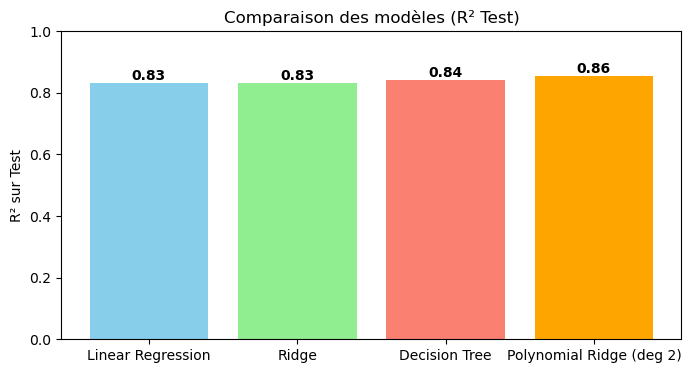

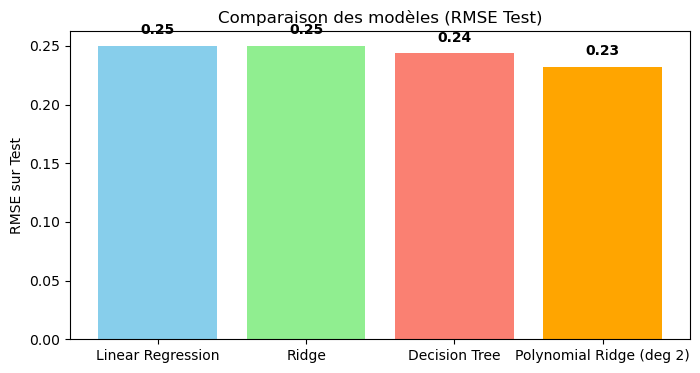

In [71]:
# ==== IMPORTS ====
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# ==== PRÉPARATION DES DONNÉES ====
df8 = df8.drop(columns=['Ville','Année-Modèle'], errors='ignore')
df8['logPrix'] = np.log1p(df8['Prix'])

# Target encoding pour Marque et Modèle
for col in ['Marque','Modèle']:
    means = df8.groupby(col)['logPrix'].mean()
    df8[col + '_te'] = df8[col].map(means)
df8 = df8.drop(columns=['Marque','Modèle'], errors='ignore')

# One-hot encoding pour autres catégorielles
cat_cols = ['Boite de vitesses','Type de carburant','Origine','Première main',"Ville_grouped"]
df8_encoded = pd.get_dummies(df8, columns=cat_cols, drop_first=True)

# Variables et cible
X = df8_encoded.drop(['Prix','logPrix'], axis=1, errors='ignore')
y = df8_encoded['logPrix']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation (optionnelle)
num_cols = ['Kilométrage', 'Age_vehicule', 'Nombre de portes', 'Puissance fiscale','Marque_te','Modèle_te']
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

# Alignement des colonnes
X_train_scaled, X_test_scaled = X_train_scaled.align(X_test_scaled, join='left', axis=1, fill_value=0)

# ==== INITIALISATION ET ENTRAÎNEMENT DES MODÈLES ====
model = LinearRegression()
ridge_model = Ridge(alpha=1.0)
tree_model = DecisionTreeRegressor(random_state=42)

poly_ridge_model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    Ridge(alpha=1.0)
)


for mdl in [model, ridge_model, tree_model,poly_ridge_model]:
    mdl.fit(X_train_scaled, y_train)

models = {
    "Linear Regression": model,
    "Ridge": ridge_model,
    "Decision Tree": tree_model,
    "Polynomial Ridge (deg 2)":poly_ridge_model
    
}

# ==== CALCUL DES MÉTRIQUES ====
r2_train_dict = {}
r2_test_dict = {}
rmse_train_dict = {}
rmse_test_dict = {}
mse_train_dict = {}
mse_test_dict = {}

for name, mdl in models.items():
    y_pred_tr = mdl.predict(X_train_scaled)
    y_pred_te = mdl.predict(X_test_scaled)
    
    r2_train_dict[name] = r2_score(y_train, y_pred_tr)
    r2_test_dict[name] = r2_score(y_test, y_pred_te)
    
    mse_train_dict[name] = mean_squared_error(y_train, y_pred_tr)
    mse_test_dict[name] = mean_squared_error(y_test, y_pred_te)
    
    rmse_train_dict[name] = np.sqrt(mse_train_dict[name])
    rmse_test_dict[name] = np.sqrt(mse_test_dict[name])

# ==== Plot comparatif R² ====
plt.figure(figsize=(8,4))
plt.bar(r2_test_dict.keys(), r2_test_dict.values(), color=['skyblue','lightgreen','salmon','orange'])
plt.ylim(0,1)
plt.ylabel("R² sur Test")
plt.title("Comparaison des modèles (R² Test)")
for i, v in enumerate(r2_test_dict.values()):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()

# ==== Plot comparatif RMSE ====
plt.figure(figsize=(8,4))
plt.bar(rmse_test_dict.keys(), rmse_test_dict.values(), color=['skyblue','lightgreen','salmon','orange'])
plt.ylabel("RMSE sur Test")
plt.title("Comparaison des modèles (RMSE Test)")
for i, v in enumerate(rmse_test_dict.values()):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()


# Corrélation des colonnes numériques avec Prix

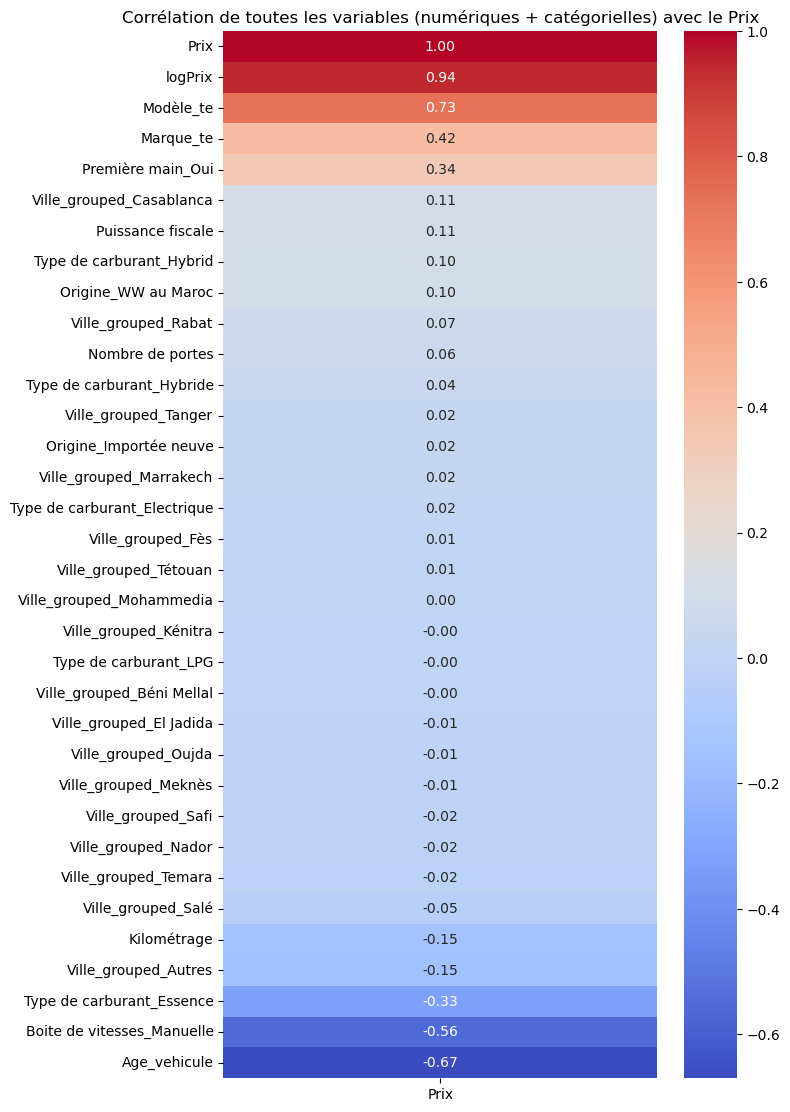

In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul des corrélations avec le prix
corr_with_price = df4_encoded.corr()['Prix'].sort_values(ascending=False)

# Affichage sous forme de heatmap
plt.figure(figsize=(7, len(corr_with_price)*0.4))
sns.heatmap(corr_with_price.to_frame(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Corrélation de toutes les variables (numériques + catégorielles) avec le Prix")
plt.show()
